# 2D Fourier transform

This notebook shows examples of 2D Fourier Transforms and their applications

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## The Fourier transform everyone should know - A hole / dot

In optics, we can treat every lens like it performs a fourier transform.
A small hole or a point like light source is therefore the easiest example.
It corresponds to the delta function / sine wave example in 1D.

First let's generate a 2D plane $N*N$, ideally of size $N=2^n$.

In [3]:
N = 256
x_size = 10
y_size = x_size # make it square
x = np.linspace(-x_size/2,x_size/2,N) # and symmetric around 0,0
y = np.linspace(-y_size/2,y_size/2,N)

Now let's make a hole

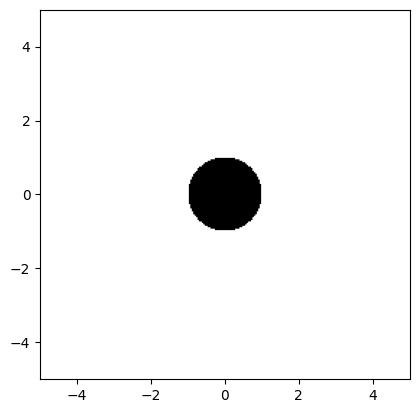

In [4]:
R = 1 # define a radius
xx, yy = np.meshgrid(x, y, sparse=True) # generate a meshgrid from our x,y coordinates
z = (np.sqrt(xx**2 + yy**2) >= R)*1  # set everything outside R and make it a number
plt.imshow(z, "gray", extent=[-x_size/2,x_size/2, -y_size/2,y_size/2])

Now let's take the Fourier transform

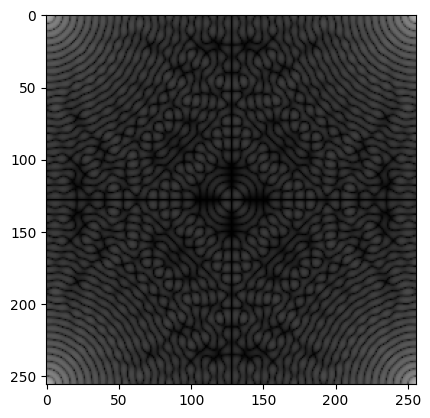

In [5]:
Fz = np.fft.fft2(z)
Fzcenter = np.fft.fftshift(Fz)
plt.imshow(np.log(1+np.abs(Fz)), "gray")

That Doesn't look right.
The frequency starts at 0,0 and not in the middle of the plane.
So let's shift it.

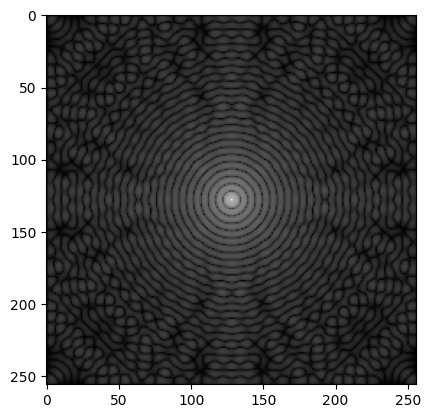

In [6]:
Fzcenter = np.fft.fftshift(Fz)
plt.imshow(np.log(1+np.abs(Fzcenter)), "gray")

Let's do some filtering.
We can reuse our "hole" to use as a mask in Fouries Space.

Let's take The inverse Fourier Transform of our filtered image:

In [7]:
from PIL import Image, ImageOps

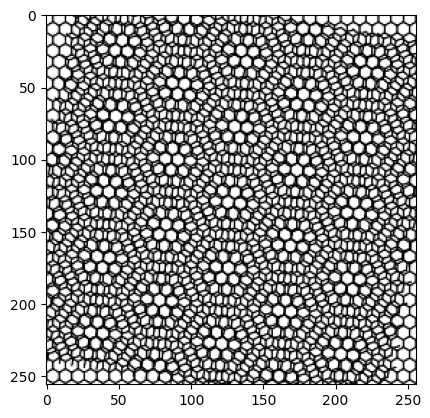

In [8]:
bilayer = np.array(ImageOps.grayscale(Image.open('lattice.png')))
plt.imshow(bilayer, "gray")

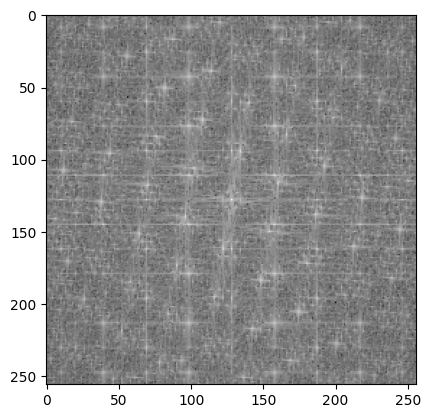

In [9]:
Fbilayer = np.fft.fft2(bilayer)
Fbilayercenter = np.fft.fftshift(Fbilayer)
plt.imshow(np.log(1+np.abs(Fbilayercenter)), "gray")

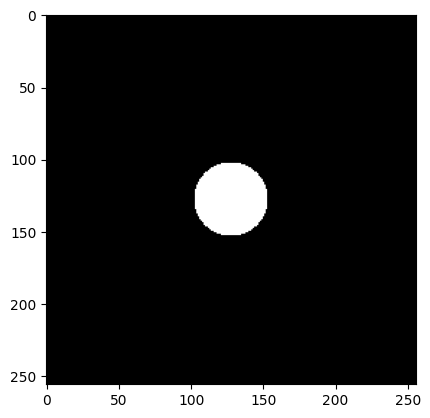

In [10]:
R = 1
xx, yy = np.meshgrid(x, y, sparse=True)
lowpass = (np.sqrt(xx**2 + yy**2) <= R)
plt.imshow(lowpass, "gray")

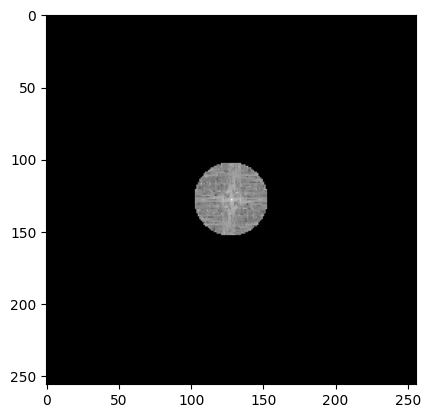

In [11]:
plt.imshow(np.log(1+np.abs(lowpass*Fbilayercenter)), "gray")

In [12]:
filtered = np.fft.ifft2(lowpass*Fbilayercenter)

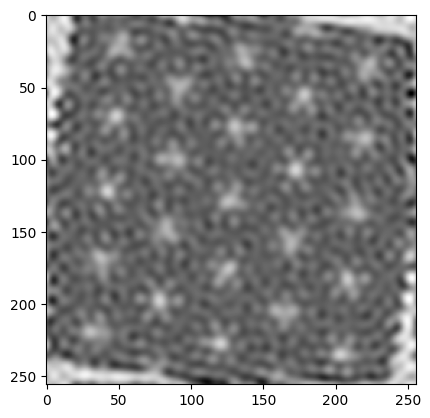

In [13]:
plt.imshow(np.log(1+np.abs(filtered)), "gray")